# <center> k-NN on Amazon Fine Food reviews Dataset</center>
___

###  <b>Exercise</b> :

1.	Download Amazon Fine Food Reviews dataset from Kaggle. You may have to create a Kaggle account to download data. (https://www.kaggle.com/snap/amazon-fine-food-reviews)
2.	Perform featurization, BoW, tf-idf,Avg Word2Vec, tf-idf-Word2Vec.
3.	Split data into train and test using time based slicing as 70%  train & 30% test.
4.	Perform 10-fold cross validation to find optimal k.
5.	Report test accuracy for all four featurization.
6.	Write your observations in English as crisply and unambiguously as possible. Always quantify your results.

### Information regarding data set :

1. <b>Title</b>: Amazon Fine Food Reviews Data

2. <b>Sources</b>: Stanford Network Analysis Project(SNAP)

3. <b>Relevant Information</b>: This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~568,454 reviews up to October 2012(Oct 1999 - Oct 2012). Reviews include product and user information, ratings, and a plain text review.
4.  <b>Attribute Information</b>:   
    <b>ProductId </b>- unique identifier for the product <br/>
    <b>UserId </b>- unqiue identifier for the user <br/>
    <b>ProfileName </b>- name of the user <br/>
    <b>HelpfulnessNumerator </b>- number of users who found the review helpful <br/>
    <b>HelpfulnessDenominator </b>- number of users who indicated whether they found the review helpful or not <br/>
    <b>Score </b>- rating between 1 and 5.( rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored) <br/>
    <b>Time </b>- timestamp for the review <br/> 
    <b>Summary </b>- brief summary of the review <br/>
    <b>Text </b>- text of the review <br/>

---

### <b>Objective :</b> 
> <span style="color:blue">It is a 2-class classification task, where we have to analyze, transform(BoW,TF-IDF,AVG-W2V,TF-IDF-W2V) and calculate probabilistic class label values, which evaluates whether a review is positive or negative.<span>

---


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning,module='gensim')
warnings.filterwarnings("ignore", category=UserWarning)

from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")

import traceback
import sqlite3
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sn
import itertools
from tqdm import tqdm
from sklearn import preprocessing 
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import TruncatedSVD
from gensim.models import Word2Vec
from prettytable import PrettyTable
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import make_scorer,accuracy_score,confusion_matrix,classification_report

### (1) Load dataset :

Dataset Shape : 
 (100000, 11)

Column Names: 
 Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'CleanedText'],
      dtype='object')

Target Class label : 
positive    88009
negative    11991
Name: Score, dtype: int64



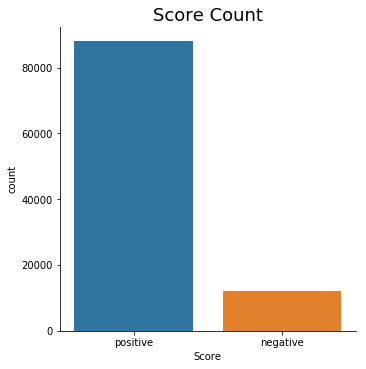

In [4]:
# Load 'finalDataSet.sqlite' in panda's daraframe.
# This dataset is already gone through data deduplication and text preprocessing, so it is approx ~364K

# Create connection object to load sqlite dataset
connection = sqlite3.connect('finalDataSet.sqlite')

# Load data into pandas dataframe.
reviews_df = pd.read_sql_query(""" SELECT * FROM Reviews """,connection)

# Drop index column 
reviews_df = reviews_df.drop(columns=['index'])

# Convert timestamp to datetime.
reviews_df['Time'] = reviews_df[['Time']].applymap(lambda x: dt.datetime.fromtimestamp(x))

# Sort the data on the basis of time.
reviews_df = reviews_df.sort_values(by=['Time'])

# Take first 100K sample of reviews
reviews_df = reviews_df.head(100000)

print("Dataset Shape : \n",reviews_df.shape)
print("\nColumn Names: \n",reviews_df.columns)
print("\nTarget Class label : ")
print(reviews_df['Score'].value_counts())
print()

# Split data into 70% training and 30% testing.
x_train_original,x_test_original,y_train_original,y_test_original = train_test_split(reviews_df['CleanedText'].values,
                                                                                     reviews_df['Score'].values,
                                                                                     test_size=0.3,
                                                                                     shuffle=False,
                                                                                     random_state=0)


# Plot review counts
plot_count_values(reviews_df)

In [8]:
###--- All utility variables and functions ---###

# List of odd numbers from 0 to 30
neighbors = list(filter(lambda x: x % 2 != 0, list(range(0,30))))

# Training Error
train_error = []

# Test Error
test_error = []

# Test Error
list_k = []

# http://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter 
# for list allowed scoring values
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}

scoring_parameter = "Accuracy, Precision, Recall"

# Target Classes
target_classes = ["negative", "positive"]

def get_optimal_k(x_train, y_train,algorithm_name):
    '''
    This function, plots error and k values and, then returns optimal k value.    
    '''
    scores = dict()
    
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Optimal K : 10-Fold Cross Validation"
    ptable.field_names = ["K Value", "Cross Validation Scoring Mean","Scoring Parameter Used"]    
    
    # Perform 10-fold cross validation
    for k in neighbors:
        knn_classifier = KNeighborsClassifier(n_neighbors=k,algorithm=algorithm_name,n_jobs=-1)
        result = cross_val_score(knn_classifier, x_train, y_train, cv=10, scoring=custom_scorer)
        scores[k] = result.mean()
        ptable.add_row([k, scores[k], scoring_parameter])
    
    # Print pretty table values  
    print(ptable)
    
    # Plot the value of alpha's(x-axis) and crosss validation scoring(accuracy,precision,recall)(y-axis)
    plt.plot(scores.keys(),scores.values())
    plt.xlabel("Value of k for k-NN")
    plt.ylabel("Cross validated scoring - accuracy,precision,recall")
    plt.show()
    
    optimal_k = max(scores, key=scores.get)
    list_k.append(optimal_k)
    print("\nOptimal value of hyperparameter k is ",optimal_k)
        
    return optimal_k


def getScores(estimator, x, y):
    yPred = estimator.predict(x)
    return (accuracy_score(y, yPred), 
            precision_score(y, yPred, pos_label=3, average='macro'), 
            recall_score(y, yPred, pos_label=3, average='macro'))

def custom_scorer(estimator, x, y):
    a, p, r = getScores(estimator, x, y)    
    return a+p+r



def apply_k_nn(algorithm_name,optimal_k,x_train,y_train):
    '''
    This funtion tries to fit the model and returns the corresponding classifier.
    '''
    # instantiate learning model k with optimal_k and specified algorithm(brute,kd-tree)
    knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k,algorithm=algorithm_name,n_jobs=-1)

    # Fitting the model.   
    knn_classifier.fit(x_train, y_train)   
    
    return knn_classifier
   
    
def plot_count_values(reviews_df):   
    sn.catplot(x ="Score",kind='count',data=reviews_df,height=5)
    plt.title("Score Count", fontsize=18)
    plt.show()
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()
    
def generate_report(optimal_k, y_test, predicted_y_test):
    '''
    This funtion generate reports like recall,precision,f1-score,confusion matrix.
    '''
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Classification Report with k = {0}".format(optimal_k)
    ptable.field_names = ["Class Lable/Averages","Precision", "Recall","F1-Score","Support"]
    report_dict = classification_report(y_test, predicted_y_test,output_dict = True)
    for key , value in report_dict.items():        
        inner_dict = value        
        ptable.add_row([key,inner_dict['precision'],inner_dict['recall'],inner_dict['f1-score'],inner_dict['support']])
    
    # Print pretty table values
    print(ptable)
        
    print()
    print("\nAccuracy Score: {0}%".format(accuracy_score(y_test, predicted_y_test)*100))
    test_error.append(1-accuracy_score(y_test, predicted_y_test))
    print()
    cnf_mat = confusion_matrix(y_test, predicted_y_test)
    plt.figure()
    plot_confusion_matrix(cnf_mat, classes=target_classes,title='Confusion Matrix')
    TN = cnf_mat[0,0]       
    FP = cnf_mat[0,1]  
    FN = cnf_mat[1,0]
    TP = cnf_mat[1,1]
    

    # Sensitivity, hit rate, recall, or true positive rate
    TPR = TP/(TP+FN)
    
    # Specificity or true negative rate
    TNR = TN/(TN+FP)  
    
    # Fall out or false positive rate
    FPR = FP/(FP+TN)
    
    # False negative rate
    FNR = FN/(TP+FN)
    
    # Overall accuracy
    ACC = (TP+TN)/(TP+FP+FN+TN)
    
    print()
    # Pretty table instance
    ptable = PrettyTable()
    ptable.title = "Confusion Matrix Report"
    ptable.field_names = ['Term','Value']
    ptable.add_row(["TP (True Positive)",TP])
    ptable.add_row(["TN (True Negative)",TN])
    ptable.add_row(["FP (False Positive)",FP])
    ptable.add_row(["FN (False Negative)",FN])
    ptable.add_row(["TPR (True Positive Rate)= TP/(TP+FN))",TPR])
    ptable.add_row(["TNR (True Negative Rate)= TN/(TN+FP))",TNR])
    ptable.add_row(["FPR (False Positive Rate)= FP/(FP+TN))",FPR])
    ptable.add_row(["FNR (False Negative Rate)= FN/(TP+FN))",FNR])
    ptable.add_row(["ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN))",ACC])
    
    # Print pretty table values
    print(ptable)

def conclude():
    ptable=PrettyTable()
    ptable.title = "***Conclusion***"
    ptable.field_names=["Vectorizer","Model","Algorithm","Hyperparameter(k)","Train Error","Test Error"]
    ptable.add_row(["BoW",
                    "K-NN",
                    "Brute-Force Search",
                    list_k[0],
                    str(round(train_error[0], 2)*100)+"%",
                    str(round(test_error[0], 2)*100)+"%"])
    ptable.add_row(["BoW",
                    "K-NN",
                    "KD-Tree",
                    list_k[1],
                    str(round(train_error[1], 2)*100)+"%",
                    str(round(test_error[1], 2)*100)+"%"])
  
       
    ptable.add_row(["TF-IDF",
                    "K-NN",
                    "Brute-Force Search",
                    list_k[2],
                    str(round(train_error[2], 2)*100)+"%",
                    str(round(test_error[2], 2)*100)+"%"])
    ptable.add_row(["TF-IDF",
                    "K-NN",
                    "KD-Tree",
                    list_k[3],
                    str(round(train_error[3], 2)*100)+"%",
                    str(round(test_error[3], 2)*100)+"%"])
    
    ptable.add_row(["AVG W2V",
                    "K-NN",
                    "Brute-Force Search",
                    list_k[4],
                    str(round(train_error[4], 2)*100)+"%",
                    str(round(test_error[4], 2)*100)+"%"])
    ptable.add_row(["AVG W2V",
                    "K-NN",
                    "KD-Tree",
                    list_k[5],
                    str(round(train_error[5], 2)*100)+"%",
                    str(round(test_error[5], 2)*100)+"%"])
    
    ptable.add_row(["TF-IDF W2V",
                    "K-NN",
                    "Brute-Force Search",
                    list_k[6],
                    str(round(train_error[6], 2)*100)+"%",
                    str(round(test_error[6], 2)*100)+"%"])
    ptable.add_row(["TF-IDF W2V",
                    "K-NN",
                    "KD-Tree",
                    list_k[7],
                    str(round(train_error[7], 2)*100)+"%",
                    str(round(test_error[7], 2)*100)+"%"])

    print(ptable)


def run_knn(x_train,y_train,x_test,y_test,chosen_algorithm = None):
    algorithms = chosen_algorithm  
    
    for algorithm_name in algorithms:
               
        if algorithm_name == 'brute':
            print()
            print("\n**********************************************************************")
            print("-------------------------- Brute-Force Search Algorithm --------------")
            print("**********************************************************************\n")
        else:
            print("\n\n")          
            print("\n**********************************************************************")
            print("-------------------------- KD-Tree Algorithm --------------------------") 
            print("**********************************************************************\n")
        
        
        
        if(algorithm_name == "kd_tree"):
            print("\nPerforming TruncatedSVD, which will return dense matrix with lower dimensions...\n")
            svd = TruncatedSVD(n_components = 100)           
            x_train = svd.fit_transform(x_train)
            x_test = svd.transform(x_test)
            
        # Find optimal K
        optimal_k = get_optimal_k(x_train, y_train,algorithm_name)
            
        
        # Perform naive bayes
        classifier = apply_k_nn(algorithm_name,optimal_k,x_train,y_train)

        # Make class predictions for x_test
        # Also make class predictions for x_train(training error)
        predicted_y_test = classifier.predict(x_test)
        predicted_y_train = classifier.predict(x_train)
        train_error.append(1 - accuracy_score(y_train, predicted_y_train))     

        # Generate report
        generate_report(optimal_k,y_test,predicted_y_test)    
  

### (2) Convert review text to vector representation and perform k-NN on the corresponding vector :
#### (2.1) Bag of Words (BoW) :

#### Note: KD-Tree is computationaly very costly for high demensional dataset, so we will use truncatedSVD to reduce the dimensionality of data.
<br/>

In [5]:
%%time

# Instantiate CountVectorizer (vectorizer)
bow_count_vectorizer = CountVectorizer()

# learn the 'vocabulary' of the training data (occurs in-place)
bow_count_vectorizer.fit(x_train_original)

# Transform training and testing data(features) into a 'document-term matrix' or 'row-column matrix'
x_train_dtm = bow_count_vectorizer.transform(x_train_original)
x_test_dtm = bow_count_vectorizer.transform(x_test_original)

# Data Standardization
sc = StandardScaler(with_mean=False)
x_train_dtm = sc.fit_transform(x_train_dtm)
x_test_dtm = sc.transform(x_test_dtm)


print("\nthe type of count vectorizer ",type(x_train_dtm))
print("the shape of BOW vectorizer ",x_train_dtm.get_shape())
print("the number of unique words ", x_train_dtm.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of BOW vectorizer  (70000, 36118)
the number of unique words  36118
Wall time: 4.15 s




**********************************************************************
-------------------------- Brute-Force Search Algorithm --------------
**********************************************************************

+-----------------------------------------------------------------------+
|                  Optimal K : 10-Fold Cross Validation                 |
+---------+-------------------------------+-----------------------------+
| K Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+---------+-------------------------------+-----------------------------+
|    1    |       1.9758874015270744      | Accuracy, Precision, Recall |
|    3    |       2.0815822586119976      | Accuracy, Precision, Recall |
|    5    |        2.13608057674377       | Accuracy, Precision, Recall |
|    7    |       2.1807375724696216      | Accuracy, Precision, Recall |
|    9    |       2.230342253354761       | Accuracy, Precision, Recall |
|    11   |       2.2487415924844205      | 

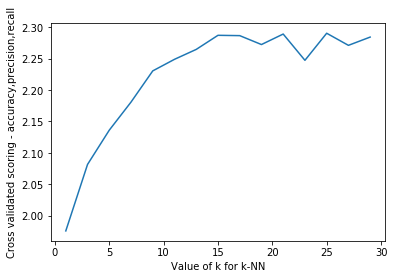


Optimal value of hyperparameter k is  25

+---------------------------------------------------------------------------------------------------+
|                                 Classification Report with k = 25                                 |
+----------------------+--------------------+----------------------+----------------------+---------+
| Class Lable/Averages |     Precision      |        Recall        |       F1-Score       | Support |
+----------------------+--------------------+----------------------+----------------------+---------+
|       negative       | 0.8666666666666667 | 0.006542526421741319 | 0.012987012987012986 |   3974  |
|       positive       | 0.8682682682682683 |  0.9998463075386153  |  0.929423530252161   |  26026  |
|      micro avg       | 0.8682666666666666 |  0.8682666666666666  |  0.8682666666666666  |  30000  |
|      macro avg       | 0.8674674674674675 |  0.5031944169801783  |  0.471205271619587   |  30000  |
|     weighted avg     | 0.868056109442

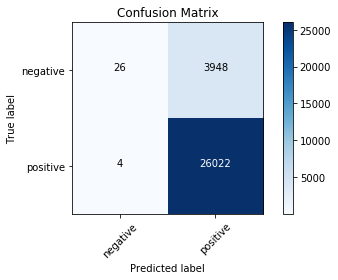


+-----------------------------------------------------------------+
|                     Confusion Matrix Report                     |
+----------------------------------------+------------------------+
|                  Term                  |         Value          |
+----------------------------------------+------------------------+
|           TP (True Positive)           |         26022          |
|           TN (True Negative)           |           26           |
|          FP (False Positive)           |          3948          |
|          FN (False Negative)           |           4            |
| TPR (True Positive Rate)= TP/(TP+FN))  |   0.9998463075386153   |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.006542526421741319  |
| FPR (False Positive Rate)= FP/(FP+TN)) |   0.9934574735782586   |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.00015369246138476907 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |   0.8682666666666666   |
+----------------------------------------+-----

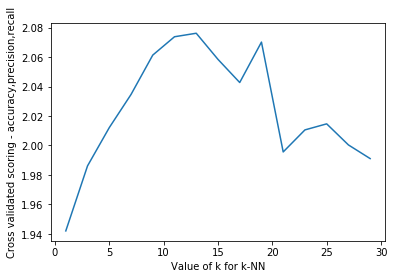


Optimal value of hyperparameter k is  13

+---------------------------------------------------------------------------------------------------+
|                                 Classification Report with k = 13                                 |
+----------------------+--------------------+----------------------+----------------------+---------+
| Class Lable/Averages |     Precision      |        Recall        |       F1-Score       | Support |
+----------------------+--------------------+----------------------+----------------------+---------+
|       negative       | 0.5076923076923077 | 0.008303975842979365 | 0.016340678385739042 |   3974  |
|       positive       | 0.8683480875229664 |  0.9987704603089218  |  0.9290041278747699  |  26026  |
|      micro avg       | 0.8675666666666667 |  0.8675666666666667  |  0.8675666666666667  |  30000  |
|      macro avg       | 0.688020197607637  |  0.5035372180759505  |  0.4726724031302545  |  30000  |
|     weighted avg     | 0.820573218554

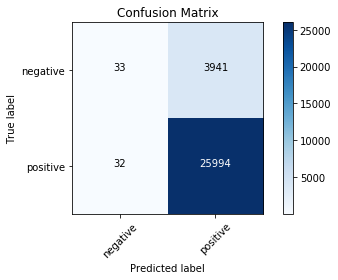


+----------------------------------------------------------------+
|                    Confusion Matrix Report                     |
+----------------------------------------+-----------------------+
|                  Term                  |         Value         |
+----------------------------------------+-----------------------+
|           TP (True Positive)           |         25994         |
|           TN (True Negative)           |           33          |
|          FP (False Positive)           |          3941         |
|          FN (False Negative)           |           32          |
| TPR (True Positive Rate)= TP/(TP+FN))  |   0.9987704603089218  |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.008303975842979365 |
| FPR (False Positive Rate)= FP/(FP+TN)) |   0.9916960241570206  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.0012295396910781526 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |   0.8675666666666667  |
+----------------------------------------+-------------------

In [9]:
%%time

# Perform k-NN on dataset.(BoW)
try:     
    choice = ['brute','kd_tree']
    run_knn(x_train_dtm, y_train_original, x_test_dtm, y_test_original, chosen_algorithm = choice)       
except Exception:
    traceback.print_exc()

#### (2.2) Term Frequency - Inverse Document Frequency (TF-IDF) :

In [10]:
%%time

# Instantiate TfidfVectorizer (vectorizer)
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# learn the 'vocabulary' of the training data (occurs in-place)
tfidf_vectorizer.fit(x_train_original)

# Transform training and testing data(features) into a 'document-term matrix' or 'row-column matrix'
x_train_dtm = tfidf_vectorizer.transform(x_train_original)
x_test_dtm = tfidf_vectorizer.transform(x_test_original)

# Data Standardization
x_train_dtm = sc.fit_transform(x_train_dtm)
x_test_dtm = sc.transform(x_test_dtm)


print("\nthe type of count vectorizer ",type(x_train_dtm))
print("the shape of TF-IDF vectorizer ",x_train_dtm.get_shape())
print("the number of unique words ", x_train_dtm.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of TF-IDF vectorizer  (70000, 162272)
the number of unique words  162272
Wall time: 14 s




**********************************************************************
-------------------------- Brute-Force Search Algorithm --------------
**********************************************************************

+-----------------------------------------------------------------------+
|                  Optimal K : 10-Fold Cross Validation                 |
+---------+-------------------------------+-----------------------------+
| K Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+---------+-------------------------------+-----------------------------+
|    1    |       1.981832064764698       | Accuracy, Precision, Recall |
|    3    |       1.8281608045616953      | Accuracy, Precision, Recall |
|    5    |       1.8281839821964732      | Accuracy, Precision, Recall |
|    7    |       1.8282071499377555      | Accuracy, Precision, Recall |
|    9    |       1.8282071499377555      | Accuracy, Precision, Recall |
|    11   |       1.8282071499377555      | 

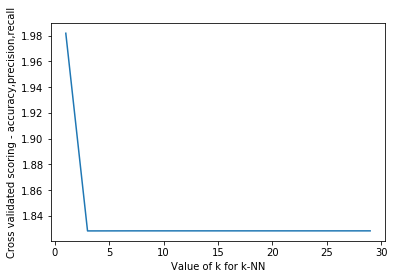


Optimal value of hyperparameter k is  1

+----------------------------------------------------------------------------------------------------+
|                                  Classification Report with k = 1                                  |
+----------------------+---------------------+----------------------+----------------------+---------+
| Class Lable/Averages |      Precision      |        Recall        |       F1-Score       | Support |
+----------------------+---------------------+----------------------+----------------------+---------+
|       negative       | 0.30714285714285716 | 0.010820332159033719 | 0.020904229460379193 |   3974  |
|       positive       |  0.868352310783657  |  0.9962729578114193  |  0.9279247038614322  |  26026  |
|      micro avg       |  0.8657333333333334 |  0.8657333333333334  |  0.8657333333333334  |  30000  |
|      macro avg       |  0.5877475839632571 |  0.5035466449852265  |  0.4744144666609057  |  30000  |
|     weighted avg     |  0.794

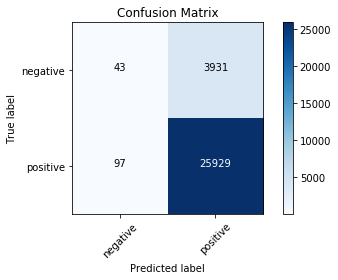


+---------------------------------------------------------------+
|                    Confusion Matrix Report                    |
+----------------------------------------+----------------------+
|                  Term                  |        Value         |
+----------------------------------------+----------------------+
|           TP (True Positive)           |        25929         |
|           TN (True Negative)           |          43          |
|          FP (False Positive)           |         3931         |
|          FN (False Negative)           |          97          |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9962729578114193  |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.010820332159033719 |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.9891796678409662  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.00372704218858065  |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.8657333333333334  |
+----------------------------------------+----------------------+




*****

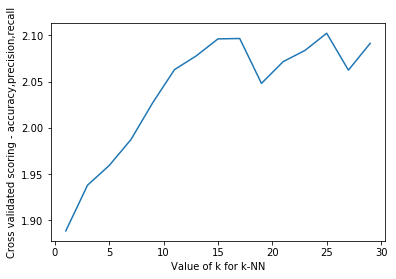


Optimal value of hyperparameter k is  25

+---------------------------------------------------------------------------------------------------+
|                                 Classification Report with k = 25                                 |
+----------------------+--------------------+----------------------+----------------------+---------+
| Class Lable/Averages |     Precision      |        Recall        |       F1-Score       | Support |
+----------------------+--------------------+----------------------+----------------------+---------+
|       negative       | 0.5454545454545454 | 0.003019627579265224 | 0.006006006006006006 |   3974  |
|       positive       | 0.8678364133698045 |  0.999615768846538   |  0.9290764945361045  |  26026  |
|      micro avg       |       0.8676       |        0.8676        |        0.8676        |  30000  |
|      macro avg       | 0.706645479412175  |  0.5013176982129016  | 0.46754125027105525  |  30000  |
|     weighted avg     | 0.825131561933

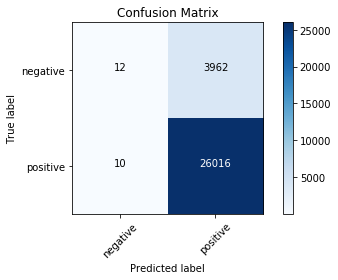


+----------------------------------------------------------------+
|                    Confusion Matrix Report                     |
+----------------------------------------+-----------------------+
|                  Term                  |         Value         |
+----------------------------------------+-----------------------+
|           TP (True Positive)           |         26016         |
|           TN (True Negative)           |           12          |
|          FP (False Positive)           |          3962         |
|          FN (False Negative)           |           10          |
| TPR (True Positive Rate)= TP/(TP+FN))  |   0.999615768846538   |
| TNR (True Negative Rate)= TN/(TN+FP))  |  0.003019627579265224 |
| FPR (False Positive Rate)= FP/(FP+TN)) |   0.9969803724207348  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.0003842311534619227 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |         0.8676        |
+----------------------------------------+-------------------

In [11]:
%%time

# Perform k-NN on dataset.(BoW)
try:     
    choice = ['brute','kd_tree']
    run_knn(x_train_dtm, y_train_original, x_test_dtm, y_test_original, chosen_algorithm = choice)       
except Exception:
    traceback.print_exc()

#### (2.3) Average Word2Vec :

In [19]:
%%time

# Make list of list from training data
list_of_sentences_in_train=[]
for sentence in x_train_original:
    list_of_sentences_in_train.append(sentence.split())
        
# Make list of list from testing data - this will be useful when vectorizing testing data.
list_of_sentences_in_test=[]
for sentence in x_test_original:
    list_of_sentences_in_test.append(sentence.split())
        
print("Shape of training data : ",x_train_original.shape)
print("Shape of testing data : ",x_test_original.shape)
print("Number of sentences present in training data : ",len(list_of_sentences_in_train))
print("Number of sentences present in testing data : ",len(list_of_sentences_in_test))
            

# Generate model.
w2v_model = Word2Vec(list_of_sentences_in_train,min_count=3,size=101, workers=6)

w2v_words =  list(w2v_model.wv.vocab)
print("Length of vocabulary : ",len(w2v_words))

# Prepare train vectorizer using trained word2vec model
train_list = []
for sentence in tqdm(list_of_sentences_in_train,unit=" sentence",desc='Average Word2Vec - Train data'):
    word_2_vec = np.zeros(101)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    train_list.append(word_2_vec)

# Prepare test vectorizer using trained word2vec model
test_list = []
for sentence in tqdm(list_of_sentences_in_test,unit=" sentence",desc='Average Word2Vec - Test data'):
    word_2_vec = np.zeros(101)
    cnt_words = 0
    for word in sentence:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            word_2_vec += vec
            cnt_words += 1
    if cnt_words != 0 :
        word_2_vec /= cnt_words
    test_list.append(word_2_vec)

avg_w2v_train = np.array(train_list)
avg_w2v_test = np.array(test_list)

Shape of training data :  (70000,)
Shape of testing data :  (30000,)
Number of sentences present in training data :  70000
Number of sentences present in testing data :  30000
Length of vocabulary :  13792


Average Word2Vec - Test data: 100%|██████████████████████████████████████| 30000/30000 [00:57<00:00, 519.26 sentence/s]


Wall time: 3min 14s




**********************************************************************
-------------------------- Brute-Force Search Algorithm --------------
**********************************************************************

+-----------------------------------------------------------------------+
|                  Optimal K : 10-Fold Cross Validation                 |
+---------+-------------------------------+-----------------------------+
| K Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+---------+-------------------------------+-----------------------------+
|    1    |       2.1628714206952155      | Accuracy, Precision, Recall |
|    3    |       2.2551569323385814      | Accuracy, Precision, Recall |
|    5    |       2.2871062765765644      | Accuracy, Precision, Recall |
|    7    |       2.2996565698373597      | Accuracy, Precision, Recall |
|    9    |       2.308852176035892       | Accuracy, Precision, Recall |
|    11   |        2.31511878310089       | 

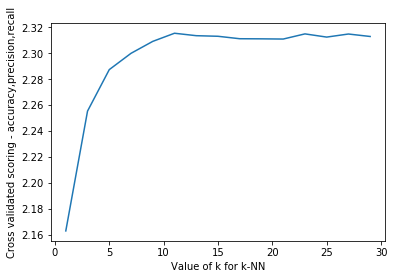


Optimal value of hyperparameter k is  11

+-------------------------------------------------------------------------------------------------+
|                                Classification Report with k = 11                                |
+----------------------+--------------------+---------------------+---------------------+---------+
| Class Lable/Averages |     Precision      |        Recall       |       F1-Score      | Support |
+----------------------+--------------------+---------------------+---------------------+---------+
|       negative       | 0.7321848081440877 | 0.23527931555108203 | 0.35612264330603693 |   3974  |
|       positive       | 0.8941962886885074 |  0.9868592945516023 |  0.938245447405432  |  26026  |
|      micro avg       |       0.8873       |        0.8873       |        0.8873       |  30000  |
|      macro avg       | 0.8131905484162976 |  0.6110693050513422 |  0.6471840453557345 |  30000  |
|     weighted avg     | 0.8727351678990566 |        0.88

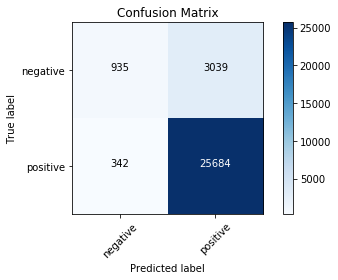


+---------------------------------------------------------------+
|                    Confusion Matrix Report                    |
+----------------------------------------+----------------------+
|                  Term                  |        Value         |
+----------------------------------------+----------------------+
|           TP (True Positive)           |        25684         |
|           TN (True Negative)           |         935          |
|          FP (False Positive)           |         3039         |
|          FN (False Negative)           |         342          |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9868592945516023  |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.23527931555108203  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.7647206844489179  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.013140705448397755 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |        0.8873        |
+----------------------------------------+----------------------+




*****

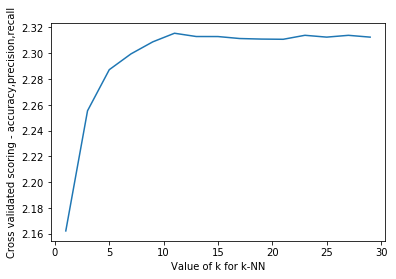


Optimal value of hyperparameter k is  11

+-------------------------------------------------------------------------------------------------+
|                                Classification Report with k = 11                                |
+----------------------+--------------------+---------------------+---------------------+---------+
| Class Lable/Averages |     Precision      |        Recall       |       F1-Score      | Support |
+----------------------+--------------------+---------------------+---------------------+---------+
|       negative       |     0.73046875     | 0.23527931555108203 | 0.35591929958127144 |   3974  |
|       positive       | 0.8941852367688022 |  0.9867440252055637 |  0.9381872648230007 |  26026  |
|      micro avg       |       0.8872       |        0.8872       |        0.8872       |  30000  |
|      macro avg       | 0.8123269933844011 |  0.6110116703783228 |  0.6470532822021361 |  30000  |
|     weighted avg     | 0.8724982594881615 |        0.88

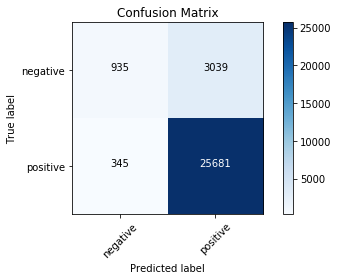


+---------------------------------------------------------------+
|                    Confusion Matrix Report                    |
+----------------------------------------+----------------------+
|                  Term                  |        Value         |
+----------------------------------------+----------------------+
|           TP (True Positive)           |        25681         |
|           TN (True Negative)           |         935          |
|          FP (False Positive)           |         3039         |
|          FN (False Negative)           |         345          |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9867440252055637  |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.23527931555108203  |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.7647206844489179  |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.013255974794436333 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |        0.8872        |
+----------------------------------------+----------------------+
Wall time

In [20]:
%%time

# Perform k-NN on dataset.(AVG-W2V)
try:
    choice = ['brute','kd_tree']
    run_knn(avg_w2v_train, y_train_original, avg_w2v_test, y_test_original, chosen_algorithm = choice)    
except Exception:
    traceback.print_exc()

#### (2.4) Term Frequency - Inverse Document Frequency Weighted Word2Vec (TF-IDF-Word2Vec) :

In [21]:
%%time

# Make list of list from training data.      
sentences_in_train=[]
for sentence in x_train_original:
    sentences_in_train.append(sentence.split())
        
# Make list of list from testing data - this will be useful when vectorizing testing data.
sentences_in_test=[]
for sentence in x_test_original:
    sentences_in_test.append(sentence.split())
    
# Generate model
w2v_model = Word2Vec(sentences_in_train,min_count=3,size=101, workers=6)

# Instantiate TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(min_df = 3,ngram_range=(1,2))

# Tokenize and build vocab
tfidf_vectorizer.fit(x_train_original)

# Encode document
x_train_matrix = tfidf_vectorizer.transform(x_train_original)

# Get feature names
feature_names = tfidf_vectorizer.get_feature_names()

# Dictionary with word as a key, and the idf as a value
dict_word_idf = dict(zip(feature_names, list(tfidf_vectorizer.idf_)))


# Prepare train vectorizer using trained word2vec model        
train_list = []
row = 0
for sentence in tqdm(sentences_in_train,unit=" sentence",desc='TF-IDF Weighted Word2Vec - Train data'):
    word_2_vec = np.zeros(101)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    train_list.append(word_2_vec)
    row += 1
        
# Prepare test vectorizer using trained word2vec model
test_list = []
row = 0
for sentence in tqdm(sentences_in_test, unit=" sentence",desc='TF-IDF Weighted Word2Vec - Test data'):
    word_2_vec = np.zeros(101)
    weight_tfidf_sum = 0
    for word in sentence:
        try:
            vec = w2v_model.wv[word]
            # dict_word_idf[word] = idf value of word in whole courpus
            # sentence.count(word) = tf valeus of word in this review
            tfidf_value =  dict_word_idf[word]*sentence.count(word)
            word_2_vec += (vec * tfidf_value)
            weight_tfidf_sum += tfidf_value
        except:
            pass
    if weight_tfidf_sum != 0:
        word_2_vec /= weight_tfidf_sum
    test_list.append(word_2_vec)
    row += 1
        
tfidf_w2v_train = np.array(train_list)
tfidf_w2v_test = np.array(test_list)

TF-IDF Weighted Word2Vec - Test data: 100%|█████████████████████████████| 30000/30000 [00:08<00:00, 3739.67 sentence/s]


Wall time: 44.7 s




**********************************************************************
-------------------------- Brute-Force Search Algorithm --------------
**********************************************************************

+-----------------------------------------------------------------------+
|                  Optimal K : 10-Fold Cross Validation                 |
+---------+-------------------------------+-----------------------------+
| K Value | Cross Validation Scoring Mean |    Scoring Parameter Used   |
+---------+-------------------------------+-----------------------------+
|    1    |       2.112375770805098       | Accuracy, Precision, Recall |
|    3    |       2.1989783480024974      | Accuracy, Precision, Recall |
|    5    |       2.2394154812564855      | Accuracy, Precision, Recall |
|    7    |       2.2502454973864006      | Accuracy, Precision, Recall |
|    9    |       2.2564495932403306      | Accuracy, Precision, Recall |
|    11   |       2.263034368995337       | 

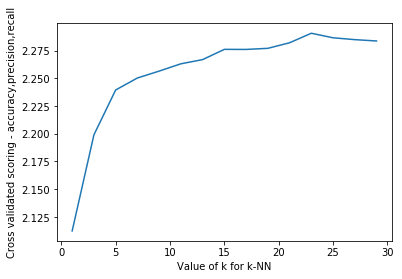


Optimal value of hyperparameter k is  23

+------------------------------------------------------------------------------------------------+
|                               Classification Report with k = 23                                |
+----------------------+--------------------+--------------------+---------------------+---------+
| Class Lable/Averages |     Precision      |       Recall       |       F1-Score      | Support |
+----------------------+--------------------+--------------------+---------------------+---------+
|       negative       | 0.7218710493046776 | 0.1436839456467036 | 0.23966421825813225 |   3974  |
|       positive       | 0.8834948132424938 | 0.9915469146238377 |  0.934407531456504  |  26026  |
|      micro avg       | 0.8792333333333333 | 0.8792333333333333 |  0.8792333333333333 |  30000  |
|      macro avg       | 0.8026829312735857 | 0.5676154301352706 |  0.5870358748573181 |  30000  |
|     weighted avg     | 0.862085051979531  | 0.8792333333333333 |

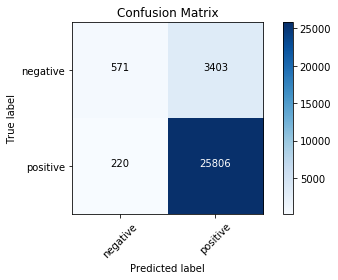


+-------------------------------------------------------------+
|                   Confusion Matrix Report                   |
+----------------------------------------+--------------------+
|                  Term                  |       Value        |
+----------------------------------------+--------------------+
|           TP (True Positive)           |       25806        |
|           TN (True Negative)           |        571         |
|          FP (False Positive)           |        3403        |
|          FN (False Negative)           |        220         |
| TPR (True Positive Rate)= TP/(TP+FN))  | 0.9915469146238377 |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.1436839456467036 |
| FPR (False Positive Rate)= FP/(FP+TN)) | 0.8563160543532964 |
| FNR (False Negative Rate)= FN/(TP+FN)) | 0.0084530853761623 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) | 0.8792333333333333 |
+----------------------------------------+--------------------+




***********************************

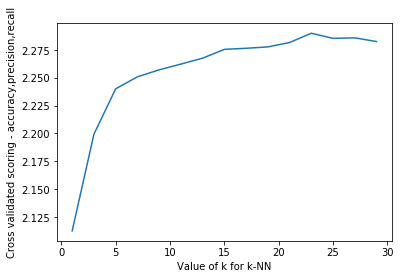


Optimal value of hyperparameter k is  23

+------------------------------------------------------------------------------------------------+
|                               Classification Report with k = 23                                |
+----------------------+--------------------+---------------------+--------------------+---------+
| Class Lable/Averages |     Precision      |        Recall       |      F1-Score      | Support |
+----------------------+--------------------+---------------------+--------------------+---------+
|       negative       | 0.7222222222222222 | 0.14393558127830902 | 0.2400335711288292 |   3974  |
|       positive       | 0.8835250616269515 |  0.9915469146238377 | 0.9344244487091284 |  26026  |
|      micro avg       | 0.8792666666666666 |  0.8792666666666666 | 0.8792666666666666 |  30000  |
|      macro avg       | 0.8028736419245869 |  0.5677412479510734 | 0.5872290099189789 |  30000  |
|     weighted avg     | 0.8621578121671384 |  0.8792666666666666 

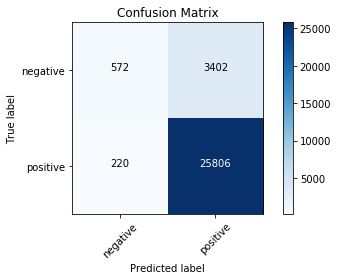


+--------------------------------------------------------------+
|                   Confusion Matrix Report                    |
+----------------------------------------+---------------------+
|                  Term                  |        Value        |
+----------------------------------------+---------------------+
|           TP (True Positive)           |        25806        |
|           TN (True Negative)           |         572         |
|          FP (False Positive)           |         3402        |
|          FN (False Negative)           |         220         |
| TPR (True Positive Rate)= TP/(TP+FN))  |  0.9915469146238377 |
| TNR (True Negative Rate)= TN/(TN+FP))  | 0.14393558127830902 |
| FPR (False Positive Rate)= FP/(FP+TN)) |  0.856064418721691  |
| FNR (False Negative Rate)= FN/(TP+FN)) |  0.0084530853761623 |
| ACC (Accuracy)= (TP+TN)/(TP+FP+FN+TN)) |  0.8792666666666666 |
+----------------------------------------+---------------------+
Wall time: 2h 57min 47s


In [22]:
%%time

# Perform k-NN on dataset.(TF-IDF W2V)
try:
    choice = ['brute','kd_tree']
    run_knn(tfidf_w2v_train,y_train_original,tfidf_w2v_test,y_test_original, chosen_algorithm = choice)        
except Exception:
    traceback.print_exc()

---
### Conclusion :
---

In [23]:
conclude()

+----------------------------------------------------------------------------------------+
|                                    ***Conclusion***                                    |
+------------+-------+--------------------+-------------------+-------------+------------+
| Vectorizer | Model |     Algorithm      | Hyperparameter(k) | Train Error | Test Error |
+------------+-------+--------------------+-------------------+-------------+------------+
|    BoW     |  K-NN | Brute-Force Search |         25        |    11.0%    |   13.0%    |
|    BoW     |  K-NN |      KD-Tree       |         13        |    11.0%    |   13.0%    |
|   TF-IDF   |  K-NN | Brute-Force Search |         1         |     0.0%    |   13.0%    |
|   TF-IDF   |  K-NN |      KD-Tree       |         25        |    11.0%    |   13.0%    |
|  AVG W2V   |  K-NN | Brute-Force Search |         11        |     9.0%    |   11.0%    |
|  AVG W2V   |  K-NN |      KD-Tree       |         11        |     9.0%    |   11.0%    |

---
### Observations :
---

> 1. After applying k-NN over BoW,TF_IDF,AVG-Word2Vec and TF_IDF-Word2Vec vectors, we can easily compare testing acccuracies for different factorization.
> 2. We have sensible confusion matrix, but stii it can be improved with more data points with balanced positive and negative points.
> 4. Because of the dense nature of the matrix, it is computationally very costly to take more number of samples to train under kd-tree, .
> 3. Different classification techniques(Like logistic regression) can be applied to find perfect classifier, which can further increase the testing accuracy.
